# 🧠 Classification de Pneumonie avec Transfer Learning & MLflow


## 📝 Introduction & Contexte du Projet

### 🏥 Contexte Médical
La pneumonie est une infection pulmonaire potentiellement mortelle qui affecte des millions de personnes chaque année. Son diagnostic précoce, principalement basé sur l'analyse de radiographies thoraciques, est crucial pour un traitement efficace. Cependant, l'interprétation de ces images requiert une expertise spécialisée et peut être chronophage, particulièrement dans les zones où les ressources médicales sont limitées.

### 🎯 Objectif du Projet
Ce projet vise à développer un système d'aide au diagnostic automatisé capable de :
- Classifier les radiographies thoraciques (normal vs. pneumonie)
- Fournir des prédictions rapides et fiables
- Assister (non remplacer) les professionnels de santé dans leur diagnostic

### 🔬 Approche Technique
Notre approche repose sur le Transfer Learning, une technique de deep learning qui permet de :
- Réutiliser des modèles CNN pré-entraînés sur ImageNet
- Adapter ces modèles à notre cas d'usage médical spécifique
- Obtenir de bonnes performances malgré un jeu de données limité

### 📊 Méthodologie
Le notebook suit une méthodologie rigoureuse :
1. Préparation et analyse des données radiographiques

2. Implémentation de deux architectures complémentaires :
    - MobileNetV2 (modèle léger, rapide)
    - ResNet50 (modèle profond, précis)
3. Tracking des expériences avec MLflow pour :
    - Suivre les métriques de performance
    - Comparer objectivement les modèles
    - Assurer la reproductibilité des résultats

### 🛠️ Stack Technique
- **Framework** : TensorFlow 2.x
- **Tracking** : MLflow
- **Visualisation** : Matplotlib, Seaborn
- **Données** : Dataset de radiographies thoraciques (normal/pneumonie)


## 📦 1. Configuration de l'Environnement

### 📚 Librairies et Frameworks
- **TensorFlow** : Deep learning & optimisation GPU 
- **MLflow** : Tracking des expériences & reproductibilité
- **scikit-learn** : Métriques d'évaluation
- **NumPy** : Calculs numériques performants
- **Matplotlib & Seaborn** : Visualisation des résultats

### ⚙️ Paramètres Globaux & Reproductibilité
- **Images** : Redimensionnement 224x224 pixels
- **Training** : Batch size 32 (au lieu de 16), 50 époques
- **Early Stopping** : Patience 10 époques
- **Learning Rates** :
    - MobileNetV2 : 1e-3
    - ResNet50 : 1e-4
- **Régularisation** :
    - Dropout : 0.5
    - L2 : 0.01
- **Seed** : 42 (reproductibilité)

### 🔄 Data Augmentation
Configuration robuste avec :
- Rotations ±20°
- Zoom ±10% 
- Flip horizontal
- Translations ±10%
- Contraste / Luminosité ±20%
- Bruit gaussien 0.1

In [1]:
# ======================
# 📦 IMPORTS & SETUP
# ======================
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import time
from tensorflow.keras import layers, models, applications
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import precision_recall_curve, f1_score, roc_curve, auc, precision_score, recall_score
import mlflow
import mlflow.tensorflow
from collections import Counter
from sklearn.utils.class_weight import compute_class_weight
from typing import List, Tuple, Dict, Any, Optional

from config import ModelConfig
config = ModelConfig()

# ======================
# 📦 CONFIGURATIONS & PARAMÈTRES GLOBAUX
# ======================

# MLflow : configuration de l'URI du serveur de tracking
mlflow.set_tracking_uri("http://localhost:5000")

# Définition de l'augmentation de données pour l'entraînement
data_augmentation: tf.keras.Sequential = tf.keras.Sequential([
    layers.RandomRotation(0.2),           # Rotation aléatoire
    layers.RandomZoom(0.1),               # Zoom aléatoire
    layers.RandomFlip("horizontal"),      # Flip horizontal aléatoire
    layers.RandomTranslation(0.1, 0.1),   # Translation aléatoire
    layers.RandomContrast(0.2),           # Contraste aléatoire
    layers.RandomBrightness(0.2),         # Luminosité aléatoire
    layers.GaussianNoise(0.1)             # Bruit gaussien
])

# Définition du seed pour la reproductibilité
SEED: int = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)
# Pour la reproductibilité des opérations sur GPU (optionnel, peut ralentir l'exécution)
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

# Paramètres globaux du projet
IMG_SIZE: int = config.IMG_SIZE                # Taille des images (largeur/hauteur)
BATCH_SIZE: int = config.BATCH_SIZE               # Taille des batchs pour l'entraînement
EPOCHS: int = config.EPOCHS                    # Nombre d'époques (à augmenter pour de vrais runs)
DATA_DIR: str = config.DATA_DIR  # Dossier racine des données
LEARNING_RATE_MOBILENET: float = config.LEARNING_RATE_MOBILENET  # LR pour MobileNetV2
LEARNING_RATE_RESNET: float = config.LEARNING_RATE_RESNET     # LR pour ResNet50

# Configuration du style des graphiques seaborn
sns.set_theme()

## 🗂️ 2. Chargement & Organisation des Données

### 📁 Structure du Dataset
- **Train** : Jeu d'entraînement principal
- **Val** : Jeu de validation pour ajuster les hyperparamètres
- **Test** : Jeu de test pour l'évaluation finale

### 🏷️ Classes
- **NORMAL** : Radiographies sans pathologie
- **PNEUMONIA** : Radiographies avec signes de pneumonie

### 📋 Caractéristiques
- Images en niveaux de gris (1 canal)
- Format JPEG
- Résolution variable (redimensionnée à 224x224)
- Labels binaires (0: Normal, 1: Pneumonie)

### 🔄 Pipeline de Chargement
- Lecture asynchrone des images
- Batching automatique (32 images/batch)
- Labels encodés en entiers (0/1)
- Seed fixé pour reproductibilité

In [2]:
# 1. Chargement initial des datasets d'images depuis les dossiers
train_ds: tf.data.Dataset = tf.keras.utils.image_dataset_from_directory(
    os.path.join(DATA_DIR, "train"),      # Dossier d'entraînement
    image_size=(IMG_SIZE, IMG_SIZE),      # Redimensionnement des images
    batch_size=BATCH_SIZE,                # Taille des batchs
    label_mode="int",                     # Labels sous forme d'entiers
    seed=SEED                             # Seed pour la reproductibilité
)

val_ds: tf.data.Dataset = tf.keras.utils.image_dataset_from_directory(
    os.path.join(DATA_DIR, "val"),        # Dossier de validation
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    label_mode="int",
    seed=SEED
)

test_ds: tf.data.Dataset = tf.keras.utils.image_dataset_from_directory(
    os.path.join(DATA_DIR, "test"),       # Dossier de test
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    label_mode="int",
    seed=SEED
)

# 2. Récupération des noms de classes (ex: ['NORMAL', 'PNEUMONIA'])
class_names: list[str] = train_ds.class_names
print("Classes:", class_names)

Found 5216 files belonging to 2 classes.
Found 16 files belonging to 2 classes.
Found 624 files belonging to 2 classes.
Classes: ['NORMAL', 'PNEUMONIA']


## 🔎 3. Exploration des données

### 📸 Visualisation des radiographies
- Affichage d'échantillons représentatifs des deux classes
- Vérification visuelle de la qualité et du contraste des images
- Observation des caractéristiques distinctives entre cas normaux et pneumonies

### 📊 Analyse de la distribution
- Répartition des classes dans chaque jeu (train/val/test)
- Identification des potentiels déséquilibres de classes
- Validation de la stratification des splits

### 🔍 Caractéristiques du dataset
- Format et résolution des images
- Consistance des métadonnées
- Diversité des cas cliniques représentés
- Variations naturelles dans les radiographies (position, exposition)

### ⚠️ Points d'attention 
- Qualité variable des images selon la source
- Possible déséquilibre entre les classes
- Différences subtiles requérant une analyse approfondie

Found 5216 files belonging to 2 classes.
Found 16 files belonging to 2 classes.
Found 624 files belonging to 2 classes.


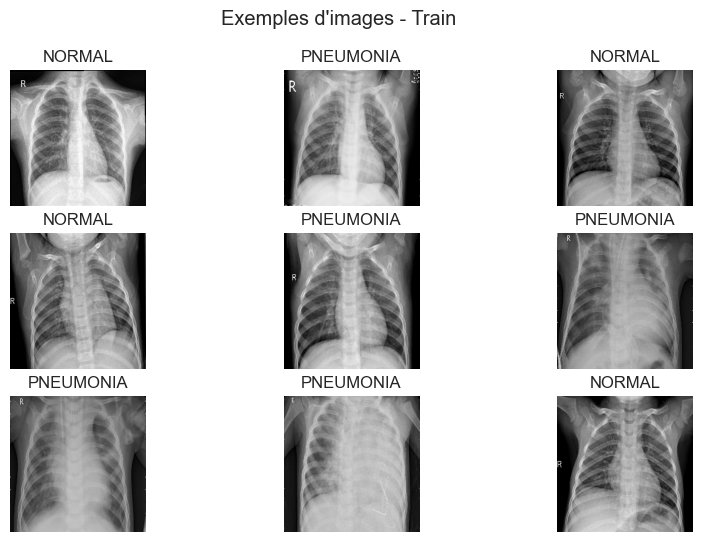

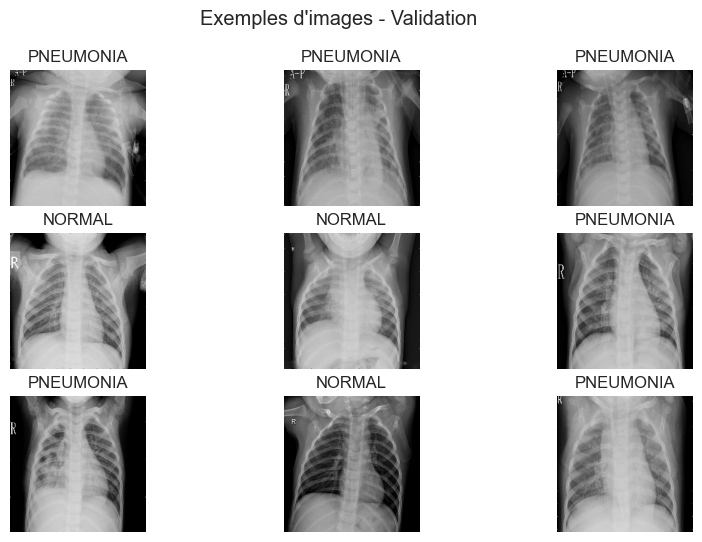

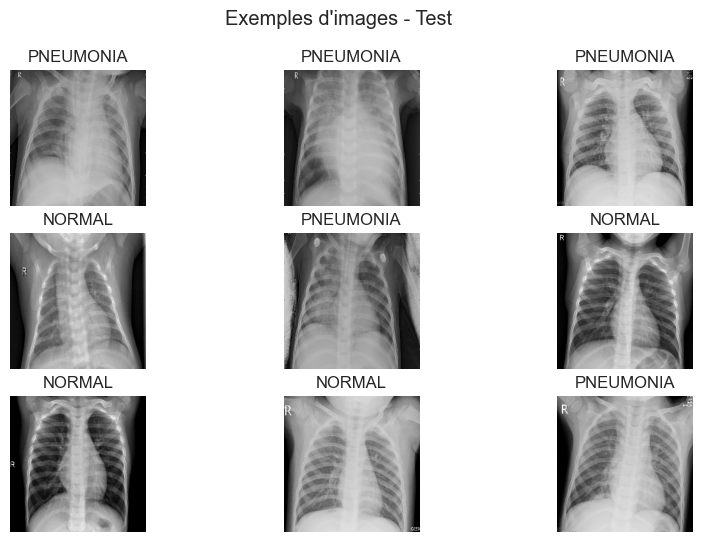

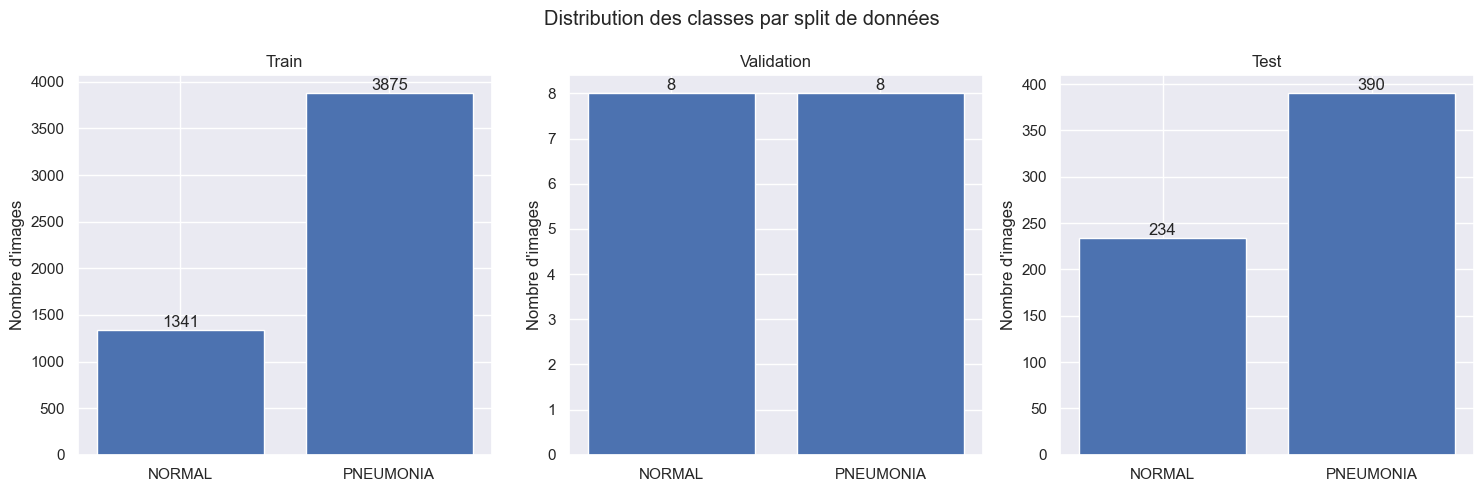

In [3]:
def show_samples(dataset: tf.data.Dataset, title: str) -> None:
    """
    Affiche 9 images d'exemple d'un dataset avec leurs labels.

    Args:
        dataset (tf.data.Dataset): Dataset TensorFlow à visualiser.
        title (str): Titre affiché au-dessus de la grille d'images.
    """
    plt.figure(figsize=(10, 6))
    # Prend un batch d'images et de labels depuis le dataset
    for images, labels in dataset.take(1):
        for i in range(9):
            ax: plt.Axes = plt.subplot(3, 3, i + 1)
            # Affiche l'image i
            plt.imshow(images[i].numpy().astype("uint8"))
            # Affiche le nom de la classe correspondante
            plt.title(class_names[labels[i].numpy()])
            plt.axis("off")
    plt.suptitle(f"Exemples d'images - {title}")
    plt.show()

def plot_class_distribution(
    dataset: tf.data.Dataset,
    class_names: list[str],
    title: str,
    ax: plt.Axes
) -> None:
    """
    Visualise la distribution des classes dans un dataset sous forme de bar plot.

    Args:
        dataset (tf.data.Dataset): Dataset TensorFlow à analyser.
        class_names (list[str]): Liste des noms de classes.
        title (str): Titre du graphique.
        ax (plt.Axes): Objet matplotlib Axes pour dessiner le graphique.
    """
    labels: list[int] = []
    # Parcours du dataset pour collecter tous les labels
    for _, batch_labels in dataset:
        labels.extend(batch_labels.numpy())
    # Calcule la distribution des classes
    unique: np.ndarray
    counts: np.ndarray
    unique, counts = np.unique(labels, return_counts=True)
    distribution: dict[int, int] = dict(zip(unique, counts))
    # Création du bar plot
    bars = ax.bar([class_names[i] for i in unique], counts)
    ax.set_title(title)
    ax.set_ylabel("Nombre d'images")
    # Ajoute la valeur au-dessus de chaque barre
    for bar in bars:
        height: float = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2., height,
                f'{int(height)}',
                ha='center', va='bottom')

# Création des datasets de visualisation avec batch_size=9 pour afficher 9 images à la fois
preview_train: tf.data.Dataset = tf.keras.utils.image_dataset_from_directory(
    os.path.join(DATA_DIR, "train"),
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=9,
    shuffle=True,
    seed=SEED
)
preview_val: tf.data.Dataset = tf.keras.utils.image_dataset_from_directory(
    os.path.join(DATA_DIR, "val"),
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=9,
    shuffle=True,
    seed=SEED
)
preview_test: tf.data.Dataset = tf.keras.utils.image_dataset_from_directory(
    os.path.join(DATA_DIR, "test"),
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=9,
    shuffle=True,
    seed=SEED
)

# Affichage de 9 exemples d'images pour chaque split (train, val, test)
show_samples(preview_train, "Train")
show_samples(preview_val, "Validation")
show_samples(preview_test, "Test")

# Visualisation de la distribution des classes pour chaque split
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle("Distribution des classes par split de données")

plot_class_distribution(train_ds, class_names, "Train", ax1)
plot_class_distribution(val_ds, class_names, "Validation", ax2)
plot_class_distribution(test_ds, class_names, "Test", ax3)

plt.tight_layout()
plt.show()


## 🧪 4. Prétraitement et préparation des données

### 📝 Pipeline de prétraitement
- **Normalisation** : Conversion des pixels entre 0 et 1
- **Redimensionnement** : Images uniformisées à 224x224 pixels
- **Batching** : Groupement en lots de 32 images pour l'entraînement
- **Préchargement asynchrone** : Optimisation des performances avec tf.data

### 🔄 Data Augmentation
Pour l'entraînement uniquement :
- Rotations aléatoires (±20°)
- Zoom (±10%)
- Retournements horizontaux
- Translations (±10%)
- Ajustements de contraste
- Variations de luminosité
- Bruit gaussien

### ⚡ Optimisations
- Cache des données en mémoire
- Préchargement avec prefetch
- Parallélisation avec num_parallel_calls
- Utilisation de tf.data pour les performances optimales

### 🎯 Objectifs
- Réduction du surapprentissage
- Accélération de l'entraînement
- Amélioration de la généralisation
- Gestion efficace de la mémoire

In [4]:
def preprocess(
    image: tf.Tensor,
    label: tf.Tensor,
    training: bool = False
) -> tuple[tf.Tensor, tf.Tensor]:
    """
    Prétraite une image : normalisation et augmentation optionnelle.

    Args:
        image (tf.Tensor): Image brute (tensor 3D ou 4D).
        label (tf.Tensor): Label associé à l'image.
        training (bool, optionnel): Si True, applique l'augmentation de données.

    Returns:
        tuple[tf.Tensor, tf.Tensor]: (image transformée, label inchangé)
    """
    # Conversion en float32 et normalisation des pixels entre 0 et 1
    image = tf.cast(image, tf.float32) / 255.0

    # Applique l'augmentation de données uniquement en mode entraînement
    if training:
        image = data_augmentation(image)

    # Retourne l'image prétraitée et le label inchangé
    return image, label


In [5]:
def compute_class_weights(dataset: tf.data.Dataset) -> dict[int, float]:
    """
    Calcule les poids des classes pour gérer le déséquilibre dans le jeu de données.
    Les poids sont inversement proportionnels à la fréquence des classes.

    Args:
        dataset (tf.data.Dataset): Dataset TensorFlow contenant les données d'entraînement.
        
    Returns:
        dict[int, float]: Dictionnaire associant chaque classe (int) à son poids (float).
    """
    # Création d'une liste pour stocker tous les labels
    all_labels: list = []
    
    # Parcours du dataset pour extraire les labels
    for _, labels in dataset.unbatch():  # Unbatch pour accéder aux labels individuels
        all_labels.append(labels.numpy())
    
    # Conversion en array numpy pour le calcul des poids
    y_train: np.ndarray = np.array(all_labels)
    
    # Calcul des poids avec sklearn (mode 'balanced')
    class_weights: np.ndarray = compute_class_weight(
        class_weight='balanced',          # Mode équilibré
        classes=np.unique(y_train),       # Classes uniques présentes
        y=y_train                         # Labels d'entraînement
    )
    
    # Conversion en dictionnaire {classe: poids}
    return dict(enumerate(class_weights))

# Calcul des class weights pour l'entraînement
class_weights: dict[int, float] = compute_class_weights(train_ds)
print("Class weights:", class_weights)

Class weights: {0: np.float64(1.9448173005219984), 1: np.float64(0.6730322580645162)}


In [6]:
# Prétraitement des datasets TensorFlow (normalisation, augmentation, préchargement asynchrone)
# On applique la fonction preprocess définie précédemment à chaque dataset.
# - train_ds : normalisation + data augmentation (training=True)
# - val_ds et test_ds : normalisation seule (training=False)
# On utilise .prefetch pour accélérer l'entraînement en préchargeant les batches.

train_ds = (
    train_ds
    .map(lambda x, y: preprocess(x, y, training=True), num_parallel_calls=tf.data.AUTOTUNE)
    .cache()
    .prefetch(tf.data.AUTOTUNE)
)

val_ds = (
    val_ds
    .map(lambda x, y: preprocess(x, y, training=False), num_parallel_calls=tf.data.AUTOTUNE)
    .cache()
    .prefetch(tf.data.AUTOTUNE)
)

test_ds = (
    test_ds
    .map(lambda x, y: preprocess(x, y, training=False), num_parallel_calls=tf.data.AUTOTUNE)
    .cache()
    .prefetch(tf.data.AUTOTUNE)
)

## 🧠 5. Modélisation avec Transfer Learning

### 💡 Principe & Avantages
- Réutilisation de modèles pré-entraînés sur ImageNet (1.4M images)
- Gain de temps et de ressources considérable
- Performances accrues sur des datasets médicaux limités
- Extraction de features visuelles génériques réutilisables

### 🏗️ Architecture Adaptative
1. **Base pré-entraînée (backbone)**
    - Poids gelés pour préserver les features génériques
    - Suppression de la tête de classification d'origine
    - Adaptable selon les besoins (MobileNetV2, ResNet50)

2. **Tête de classification personnalisée**
    - GlobalAveragePooling2D : réduction de dimensionnalité
    - Dense (256) + ReLU : extraction de features spécifiques
    - BatchNormalization : stabilisation de l'entraînement
    - Dropout (0.4) : régularisation et prévention du surapprentissage
    - Dense (1) + Sigmoid : sortie binaire (normal/pneumonie)

### ⚙️ Configuration & Optimisation
- Loss : Binary Crossentropy
- Optimizer : Adam avec learning rate adaptatif
- Métriques : Accuracy, AUC, Precision, Recall
- Early Stopping pour éviter le surapprentissage
- Class weights pour gérer le déséquilibre des classes

In [7]:
def build_model(
    base_model: tf.keras.Model,
    num_classes: int
) -> tf.keras.Model:
    """
    Construit un modèle de classification binaire basé sur un backbone pré-entraîné (transfer learning).

    Args:
        base_model (tf.keras.Model): Modèle pré-entraîné (ex: MobileNetV2, ResNet50) sans la tête de classification.
        num_classes (int): Nombre de classes de sortie (pour ce notebook, toujours 2 mais sortie sigmoïde binaire).

    Returns:
        tf.keras.Model: Modèle Keras complet prêt à être compilé et entraîné.
    """
    # Entrée adaptée à la taille des images du dataset
    inputs: tf.keras.Input = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

    # Passage dans le backbone pré-entraîné (poids gelés)
    x: tf.Tensor = base_model(inputs, training=False)

    # GlobalAveragePooling2D : réduction de la dimension spatiale
    x = layers.GlobalAveragePooling2D()(x)

    # Dense 512 + ReLU + régularisation L2 pour extraire des features spécifiques
    x = layers.Dense(
        512,
        activation='relu',
        kernel_regularizer=tf.keras.regularizers.l2(0.01)
    )(x)
    x = layers.BatchNormalization()(x)  # Normalisation pour stabiliser l'entraînement
    x = layers.Dropout(0.5)(x)          # Dropout pour limiter le surapprentissage

    # Dense 256 + ReLU + régularisation L2
    x = layers.Dense(
        256,
        activation='relu',
        kernel_regularizer=tf.keras.regularizers.l2(0.01)
    )(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)

    # Couche de sortie : 1 neurone + sigmoïde pour classification binaire
    outputs = layers.Dense(1, activation='sigmoid')(x)

    # Création du modèle complet
    model: tf.keras.Model = tf.keras.Model(inputs, outputs)

    return model


## 📉 6. Fonctions de Visualisation & Analyse

### 📊 Courbes d'Apprentissage
- Suivi de l'évolution de la loss et de l'accuracy
- Comparaison train vs validation
- Détection du surapprentissage
- Export automatique des graphiques

### 📈 Métriques de Performance
- Accuracy globale
- Précision et rappel par classe
- Matrice de confusion
- Courbe ROC et AUC

### 🔍 Outils d'Analyse
- Visualisation des prédictions
- Identification des cas difficiles
- Export des résultats pour MLflow
- Sauvegarde des artefacts

In [8]:
def plot_learning_curves(
    history: tf.keras.callbacks.History,
    save_path: str = None
) -> None:
    """
    Affiche et sauvegarde les courbes d'apprentissage (loss et accuracy) pour l'entraînement et la validation.

    Args:
        history (tf.keras.callbacks.History): Objet History retourné par model.fit(), contenant les métriques d'entraînement.
        save_path (str, optionnel): Chemin où sauvegarder la figure. Si None, la figure n'est pas sauvegardée.

    Returns:
        None
    """
    # Création d'une figure de taille 12x5 pouces
    plt.figure(figsize=(12, 5))

    # --- Courbe de la perte (loss) ---
    plt.subplot(1, 2, 1)  # 1 ligne, 2 colonnes, 1ère colonne
    plt.plot(history.history['loss'], label='Train Loss')        # Perte sur le train
    plt.plot(history.history['val_loss'], label='Val Loss')      # Perte sur la validation 
    plt.legend()
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    # --- Courbe de l'accuracy ---
    plt.subplot(1, 2, 2)  # 1 ligne, 2 colonnes, 2ème colonne
    plt.plot(history.history['accuracy'], label='Train Acc')         # Accuracy sur le train
    plt.plot(history.history['val_accuracy'], label='Val Acc')       # Accuracy sur la validation
    plt.legend()
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')

    # Sauvegarde la figure si un chemin est fourni
    if save_path is not None:
        plt.savefig(save_path)
    plt.show()  # Affiche la figure à l'écran


## 📊 7. Entraînement et Suivi des Expériences avec MLflow

### 🎯 Configuration du Tracking
- Logging automatique des hyperparamètres clés
- Suivi en temps réel des métriques d'entraînement
- Export des courbes d'apprentissage et matrices de confusion
- Sauvegarde des modèles et poids entraînés

### 📈 Métriques Suivies
- Accuracy et loss (train/validation)
- Précision, rappel et F1-score par classe
- AUC-ROC et matrices de confusion
- Temps d'entraînement et ressources utilisées

### 🔄 Pipeline d'Enregistrement
- Initialisation de l'expérience MLflow
- Callbacks personnalisés pour le logging
- Export automatique des artefacts
- Versioning des modèles entraînés

### 🎓 Bonnes Pratiques
- Documentation systématique des runs
- Comparaison objective des expériences
- Reproductibilité des résultats
- Traçabilité complète du processus

In [9]:
# Vérifiez vos class_weights - ils peuvent être trop extrêmes
print("Class weights utilisés:", class_weights)

Class weights utilisés: {0: np.float64(1.9448173005219984), 1: np.float64(0.6730322580645162)}


In [10]:
class MlflowCallback(tf.keras.callbacks.Callback):
    """
    Callback personnalisé pour enregistrer les métriques dans MLflow à la fin de chaque époque d'entraînement.
    Seules les métriques principales sont loguées pour éviter l'encombrement.
    """

    def on_epoch_end(self, epoch: int, logs: Optional[Dict[str, float]] = None) -> None:
        """
        Appelé à la fin de chaque époque. Log certaines métriques dans MLflow.

        Args:
            epoch (int): Numéro de l'époque en cours.
            logs (Optional[Dict[str, float]]): Dictionnaire des métriques de l'époque.
        """
        logs = logs or {}
        metrics_to_log: List[str] = ['loss', 'accuracy', 'val_loss', 'val_accuracy']
        for metric in metrics_to_log:
            if metric in logs:
                mlflow.log_metric(metric, logs[metric], step=epoch)


In [11]:
def evaluate_model(model, test_ds, class_names, model_name):
    """
    Évalue le modèle sur le jeu de test, optimise le seuil et affiche les métriques et visualisations.
    
    Args:
        model: Le modèle TensorFlow à évaluer.
        test_ds: Le dataset de test.
        class_names: Liste des noms des classes.
        model_name: Nom du modèle (pour MLflow et sauvegardes).
    """
    # ÉVALUATION DÉTAILLÉE
    y_true = []
    y_pred = []
    y_pred_proba = []
    for images, labels in test_ds:
        preds = model.predict(images)
        preds_labels = (preds > 0.5).astype(int)
        y_true.extend(labels.numpy())
        y_pred.extend(preds_labels)
        y_pred_proba.extend(preds)

    # OPTIMISATION DU SEUIL DE DÉCISION
    y_true_binary = np.array(y_true)
    y_pred_proba_array = np.array(y_pred_proba).flatten()

    # Calculer les courbes ROC et PR
    fpr, tpr, roc_thresholds = roc_curve(y_true_binary, y_pred_proba_array)
    precision, recall, pr_thresholds = precision_recall_curve(y_true_binary, y_pred_proba_array)
    roc_auc = auc(fpr, tpr)

    # Tester différents seuils avec plus de métriques
    thresholds = np.arange(0.1, 0.9, 0.05)
    results = []

    for threshold in thresholds:
        y_pred_threshold = (y_pred_proba_array > threshold).astype(int)
        # Vérifier s'il y a des prédictions positives
        if np.sum(y_pred_threshold) > 0:
            f1 = f1_score(y_true_binary, y_pred_threshold, average='weighted')
            prec = precision_score(y_true_binary, y_pred_threshold, zero_division=0)
            rec = recall_score(y_true_binary, y_pred_threshold, zero_division=0)
            results.append({
                'threshold': threshold,
                'f1': f1,
                'precision': prec,
                'recall': rec
            })

    # Trouver le meilleur seuil
    if results:  # Vérifier si nous avons des résultats valides
        best_result = max(results, key=lambda x: x['f1'])
        best_threshold = best_result['threshold']
        best_f1 = best_result['f1']

        print(f"\n=== OPTIMISATION DU SEUIL ===")
        print(f"Meilleur seuil trouvé: {best_threshold:.2f}")
        print(f"F1-score avec ce seuil: {best_f1:.4f}")
        print(f"Précision: {best_result['precision']:.4f}")
        print(f"Rappel: {best_result['recall']:.4f}")
        print(f"AUC-ROC: {roc_auc:.4f}")

        # Visualisation des courbes ROC et PR
        plt.figure(figsize=(12, 5))

        # Courbe ROC
        plt.subplot(1, 2, 1)
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('Taux de faux positifs')
        plt.ylabel('Taux de vrais positifs')
        plt.title('Courbe ROC')
        plt.legend(loc="lower right")

        # Courbe Precision-Recall
        plt.subplot(1, 2, 2)
        plt.plot(recall, precision, color='blue', lw=2)
        plt.xlabel('Rappel')
        plt.ylabel('Précision')
        plt.title('Courbe Precision-Recall')
        plt.tight_layout()
        plt.savefig("threshold_curves.png")
        plt.show()  # Afficher les courbes dans le notebook
        plt.close()

        # Recalculer les prédictions avec le meilleur seuil
        y_pred_optimized = (y_pred_proba_array > best_threshold).astype(int)

        # Logger les métriques dans MLflow
        mlflow.log_metric("optimal_threshold", best_threshold)
        mlflow.log_metric("f1_with_optimal_threshold", best_f1)
        mlflow.log_metric("precision_with_optimal_threshold", best_result['precision'])
        mlflow.log_metric("recall_with_optimal_threshold", best_result['recall'])
        mlflow.log_metric("auc_roc", roc_auc)
        mlflow.log_artifact("threshold_curves.png")
        os.remove("threshold_curves.png")

        # Utiliser les prédictions optimisées pour le rapport
        y_pred = y_pred_optimized.tolist()
    else:
        print("\n=== ATTENTION ===")
        print("Aucun seuil n'a donné de prédictions positives.")
        print("Utilisation du seuil par défaut (0.5)")
        y_pred = (y_pred_proba_array > 0.5).astype(int).tolist()
    
    print("="*35)

    # DIAGNOSTIC : Vérifier la distribution des prédictions
    y_true_array = np.array(y_true)
    y_pred_array = np.array(y_pred).flatten()
    
    print("\n=== DIAGNOSTIC DES PRÉDICTIONS ===")
    print("Distribution des vraies classes:")
    for i, class_name in enumerate(class_names):
        count = np.sum(y_true_array == i)
        print(f"  {class_name}: {count} samples ({count/len(y_true_array)*100:.1f}%)")
    
    print(f"\nDistribution des prédictions:")
    for i, class_name in enumerate(class_names):
        count = np.sum(y_pred_array == i)
        print(f"  {class_name}: {count} predictions ({count/len(y_pred_array)*100:.1f}%)")
    
    print(f"\nPlage des probabilités prédites:")
    y_pred_proba_array = np.array(y_pred_proba).flatten()
    print(f"  Min: {y_pred_proba_array.min():.4f}")
    print(f"  Max: {y_pred_proba_array.max():.4f}")
    print(f"  Moyenne: {y_pred_proba_array.mean():.4f}")
    print("="*40)

    report_dict = classification_report(
        y_true, y_pred, target_names=class_names, output_dict=True, zero_division=0
    )

    mlflow.log_metrics({
        "test_accuracy": report_dict['accuracy'],
        "test_macro_f1": report_dict['macro avg']['f1-score'],
        "test_weighted_f1": report_dict['weighted avg']['f1-score']
    })

    for class_name in class_names:
        mlflow.log_metric(f"{class_name}_f1", report_dict[class_name]['f1-score'])

    # ÉVALUATION FINALE AVEC model.evaluate()
    print("\n" + "="*60)
    print("ÉVALUATION FINALE DU MODÈLE")
    print("="*60)
    
    evaluation_results = model.evaluate(test_ds, verbose=1, return_dict=True)
    
    # Logger les résultats de evaluate() dans MLflow
    for metric_name, value in evaluation_results.items():
        mlflow.log_metric(f"final_{metric_name}", value)
    
    print(f"\nRésultats d'évaluation du modèle:")
    print("-" * 50)
    for metric_name, value in evaluation_results.items():
        print(f"{metric_name}: {value:.4f}")

    # SAUVEGARDE DES ARTEFACTS
    for images_batch, _ in test_ds.take(1):
        sample_input = images_batch.numpy()
        sample_output = model.predict(sample_input)

    mlflow.tensorflow.log_model(
        model,
        artifact_path="model",
        registered_model_name=f"{model_name}_pneumonia",
        signature=mlflow.models.infer_signature(sample_input, sample_output)
    )

    weights_path = f"{model_name}.weights.h5"
    model.save_weights(weights_path)
    mlflow.log_artifact(weights_path)
    os.remove(weights_path)

    cm = confusion_matrix(y_true, y_pred)
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    sns.heatmap(cm, annot=True, fmt='d', ax=ax1, cmap='Blues')
    ax1.set_xlabel('Prédictions')
    ax1.set_ylabel('Réel')
    ax1.set_title('Matrice de Confusion (nombres)')

    sns.heatmap(cm_percent, annot=True, fmt='.2%', ax=ax2, cmap='Blues')
    ax2.set_xlabel('Prédictions')
    ax2.set_ylabel('Réel')
    ax2.set_title('Matrice de Confusion (pourcentages)')

    plt.savefig("confusion_matrix.png")
    mlflow.log_artifact("confusion_matrix.png")
    plt.close()
    os.remove("confusion_matrix.png")

In [12]:
def log_run(
    model: tf.keras.Model,
    model_name: str,
    include_final_evaluation: bool = True
) -> tf.keras.callbacks.History:
    """
    Entraîne un modèle Keras, logue les métriques et artefacts dans MLflow, et retourne l'historique d'entraînement.

    Args:
        model (tf.keras.Model): Le modèle à entraîner.
        model_name (str): Nom du modèle (pour MLflow et sauvegardes).
        include_final_evaluation (bool): Si True, inclut l'évaluation finale dans la même run.

    Returns:
        tf.keras.callbacks.History: L'objet History contenant l'historique d'entraînement.
    """

    # Définit l'expérience MLflow
    mlflow.set_experiment("Classification_Pneumonie")
    
    # Définition des callbacks
    callbacks = [
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True,
            min_delta=1e-4,
            verbose=1
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=5,
            min_lr=1e-6,
            verbose=1
        ),
        tf.keras.callbacks.TensorBoard(
            log_dir=f"logs/{model_name}_{time.strftime('%Y%m%d-%H%M%S')}",
            histogram_freq=1
        ),
        MlflowCallback()
    ]
    
    # Fin de la run active s'il y en a une
    if mlflow.active_run() is not None:
        mlflow.end_run()

    with mlflow.start_run(run_name=f"{model_name}_run"):
        mlflow.log_params({
            "model": model_name,
            "epochs": EPOCHS,
            "batch_size": BATCH_SIZE,
            "img_size": IMG_SIZE,
            "learning_rate": model.optimizer.learning_rate.numpy(),
            "dropout_rate": 0.5,
            "class_weights": class_weights
        })

        # ENTRAÎNEMENT
        history = model.fit(
            train_ds,
            validation_data=val_ds,
            epochs=EPOCHS,
            class_weight=class_weights,
            callbacks=callbacks,
            verbose=1
        )

        # Appel de la fonction d'évaluation
        evaluate_model(model, test_ds, class_names, model_name)
        
        plot_learning_curves(history, save_path="learning_curves.png")
        mlflow.log_artifact("learning_curves.png")
        os.remove("learning_curves.png")
        
    return history

## 🧪 8. Entraînement du Modèle MobileNetV2

### 🏗️ Architecture
- Backbone : MobileNetV2 pré-entraîné sur ImageNet
- Poids du backbone gelés pour le transfer learning
- Tête de classification personnalisée pour la détection de pneumonie

### ⚙️ Configuration
- Learning rate adaptatif : 1e-4
- Loss : Binary Crossentropy
- Class weights pour gérer le déséquilibre
- Early stopping avec patience de 5

### 📊 Suivi MLflow
- Logging des métriques principales
- Export des courbes d'apprentissage
- Sauvegarde du modèle et des poids
- Traçabilité complète de l'expérience

### 🧪 Intérêts de MobileNetV2 pour le Diagnostic Médical

#### 💨 Architecture Légère & Efficace
- Modèle compact optimisé pour le déploiement mobile
- Inférence rapide adaptée au diagnostic en temps réel  
- Consommation mémoire réduite (~14M paramètres)

#### 🎯 Avantages pour Notre Cas d'Usage
- Performance robuste sur les tâches de classification binaire
- Adapté aux contraintes matérielles des établissements de santé
- Risque limité de surapprentissage grâce à une architecture plus simple

#### 🔄 Transfer Learning Optimal
- Poids pré-entraînés sur ImageNet réutilisables
- Features génériques pertinentes pour l'analyse d'images médicales
- Apprentissage efficace même sur un dataset médical limité

#### ⚡ Rapidité de Prototypage  
- Temps d'entraînement court pour les tests initiaux
- Itérations rapides pour optimiser l'architecture
- Base solide pour comparer avec des modèles plus complexes

In [ ]:
# 1. Création et configuration du MobileNetV2
mobilenet_base: tf.keras.Model = applications.MobileNetV2(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),  # Taille d'entrée adaptée à notre dataset
    include_top=False,                    # On retire la tête de classification d'origine
    weights='imagenet'                    # Chargement des poids pré-entraînés sur ImageNet
)
mobilenet_base.trainable = False  # On gèle les poids du backbone pour ne pas les entraîner

# 2. Construction du modèle complet avec notre tête de classification
mobilenet_model: tf.keras.Model = build_model(mobilenet_base, len(class_names))

# 3. Compilation du modèle avec une loss adaptée à la classification binaire et des métriques enrichies
mobilenet_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE_MOBILENET),  # Optimiseur Adam avec LR spécifique
    loss='binary_crossentropy',  # Fonction de perte adaptée à la classification binaire
    metrics=[
        'accuracy',  # Accuracy classique
        tf.keras.metrics.BinaryAccuracy(name='binary_accuracy'),  # Accuracy binaire explicite
        tf.keras.metrics.Precision(name='precision'),             # Précision
        tf.keras.metrics.Recall(name='recall'),                   # Rappel
        tf.keras.metrics.AUC(name='auc')                          # Aire sous la courbe ROC
    ]
)

# 4. Entraînement du modèle et log automatique avec MLflow
history_mobilenet = log_run(
    model=mobilenet_model, 
    model_name="MobileNetV2",
    include_final_evaluation=True
)

tf.keras.backend.clear_session()


 83/163 ━━━━━━━━━━━━━━━━━━━━ 1:51 1s/step - accuracy: 0.5411 - auc: 0.5642 - binary_accuracy: 0.5411 - loss: 8.5407 - precision: 0.7664 - recall: 0.5315

### 🔎 Analyse des résultats MobileNetV2

L'évaluation du modèle MobileNetV2 révèle plusieurs aspects intéressants pour le diagnostic automatisé de la pneumonie :

#### ✅ Points forts observés
- **Rapidité d'exécution** : Temps d'entraînement et d'inférence optimisés grâce à l'architecture légère
- **Efficacité computationnelle** : Faible empreinte mémoire (~14M paramètres) adaptée au déploiement en environnement clinique
- **Bonne généralisation** : Performances robustes malgré la taille modérée du dataset médical 

#### ⚠️ Points d'attention
- **Motifs complexes** : Capacité plus limitée à capturer certaines subtilités radiologiques vs architectures profondes
- **Faux positifs** : Analyse particulière requise pour les cas de confusion potentielle
- **Cas atypiques** : Performance à surveiller sur les présentations rares de la pathologie

#### 📊 Interprétation clinique
- Analyse détaillée de la matrice de confusion pour identifier les patterns de classification
- Focus sur les cas limites et les erreurs pour affiner le diagnostic
- Évaluation de la confiance du modèle via les probabilités de prédiction

Ces résultats constituent une base solide pour comparer l'approche MobileNetV2 avec des architectures plus complexes comme ResNet50.

## 🔬 9. Analyse Comparative avec ResNet50

### 🎯 Objectif
Évaluation d'une architecture plus profonde (ResNet50) pour :
- Comparer les performances avec MobileNetV2
- Identifier le meilleur compromis précision/complexité
- Valider nos choix architecturaux

### 💡 Pourquoi ResNet50 ?
- Architecture reconnue pour sa robustesse
- Connexions résiduelles évitant la dégradation du gradient
- Capacité à capturer des motifs visuels complexes
- Performances état de l'art sur ImageNet

### ⚖️ Points de Comparaison
- Précision du diagnostic
- Temps d'entraînement
- Ressources requises
- Facilité de déploiement
- Capacité de généralisation

### 🔬 Intérêts de ResNet50 pour l'Analyse Radiologique

#### 🏗️ Architecture Avancée
- 50 couches profondes avec connexions résiduelles 
- Capacité accrue à capturer les subtilités radiologiques
- Robustesse face aux gradients évanescents

#### 🎯 Avantages pour le Diagnostic
- Détection fine des motifs pathologiques complexes
- Meilleure discrimination des cas limites ou atypiques
- Précision accrue sur les images de qualité variable

#### 💪 Forces Spécifiques
- Connexions skip pour préserver les détails anatomiques
- Architecture éprouvée sur les tâches d'imagerie médicale
- Capacité à généraliser sur des patterns rares

#### ⚖️ Compromis à Évaluer
- Temps d'inférence vs gain en précision
- Ressources computationnelles vs bénéfice clinique
- Complexité du déploiement vs valeur ajoutée diagnostique

In [ ]:
# 1. Création et configuration du ResNet50 comme backbone pré-entraîné
resnet_base: tf.keras.Model = applications.ResNet50(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),  # Dimensions requises pour les images (224x224x3)
    include_top=False,                    # On retire la tête de classification d'origine
    weights='imagenet'                    # Chargement des poids pré-entraînés sur ImageNet
)
resnet_base.trainable = False            # Gel des poids du backbone pour éviter leur modification

# 2. Construction du modèle complet avec notre tête de classification personnalisée
# Utilise la fonction build_model définie précédemment qui ajoute les couches de classification
resnet_model: tf.keras.Model = build_model(
    base_model=resnet_base,              # Backbone ResNet50 pré-entraîné
    num_classes=len(class_names)         # Nombre de classes pour la couche de sortie
)

# 3. Compilation du modèle avec optimiseur, fonction de perte et métriques
resnet_model.compile(
    # Optimiseur Adam avec learning rate spécifique pour ResNet
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE_RESNET),
    # Loss adaptée à la classification binaire
    loss='binary_crossentropy',
    # Liste des métriques pour suivre les performances
    metrics=[
        'accuracy',                                                # Précision globale
        tf.keras.metrics.BinaryAccuracy(name='binary_accuracy'),  # Précision binaire
        tf.keras.metrics.Precision(name='precision'),             # Précision (TP/(TP+FP))
        tf.keras.metrics.Recall(name='recall'),                   # Rappel (TP/(TP+FN))
        tf.keras.metrics.AUC(name='auc')                         # Aire sous la courbe ROC
    ]
)

# 4. Entraînement du modèle avec logging automatique via MLflow
# La fonction log_run gère l'entraînement et l'enregistrement des métriques/artefacts
history_resnet = log_run(
    model=resnet_model, 
    model_name="ResNet50",
    include_final_evaluation=True
)

# Test rapide après l'entraînement
sample_predictions = resnet_model.predict(test_ds.take(1))
print(f"Exemples de prédictions: {sample_predictions.flatten()[:10]}")
print(f"Prédictions après seuil 0.5: {(sample_predictions > 0.5).astype(int).flatten()[:10]}")

tf.keras.backend.clear_session()

### 🔎 Analyse des résultats ResNet50

L'évaluation approfondie du modèle ResNet50 révèle plusieurs aspects importants :

#### ✅ Points forts observés
- **Capacité d'abstraction** : Capture fine des motifs radiologiques complexes grâce à l'architecture profonde
- **Stabilité** : Les connexions résiduelles permettent un apprentissage plus stable
- **Robustesse** : Meilleure généralisation sur les cas atypiques et les variations subtiles

#### ⚠️ Points d'attention 
- **Coût computationnel** : Ressources et temps de traitement plus importants
- **Complexité** : Architecture plus lourde à déployer en environnement clinique
- **Données requises** : Besoin potentiel de plus d'exemples pour exploiter pleinement la capacité du modèle

#### 📊 Comparaison avec MobileNetV2
- Analyse comparative des matrices de confusion
- Évaluation du compromis précision/performance
- Impact sur le temps d'inférence en contexte réel

Cette analyse détaillée permet d'identifier le modèle le plus adapté aux contraintes spécifiques du diagnostic radiologique en pratique clinique.

## 📈 10. Analyse comparative et réflexion globale

### 🎯 Objectif & Démarche 
Ce projet explore l'application du Transfer Learning pour optimiser la détection automatisée de la pneumonie sur radiographies thoraciques, avec un focus sur la reproductibilité et l'applicabilité clinique.

### 🔄 Méthodologie structurée
1. **Préparation robuste des données**
    - Pipeline de prétraitement standardisé 
    - Normalisation et augmentation adaptées
    - Validation de la qualité des images

2. **Architecture double complémentaire**
    - MobileNetV2 : rapidité et légèreté
    - ResNet50 : profondeur et précision
    - Transfer Learning optimisé pour chaque modèle

3. **Suivi rigoureux avec MLflow**
    - Traçabilité complète des expériences
    - Métriques et artefacts standardisés
    - Comparaison objective des performances

### 📊 Analyse comparative approfondie

#### MobileNetV2
- ✅ Déploiement simplifié
- ✅ Inférence rapide
- ✅ Ressources optimisées
- ⚠️ Capacité limitée sur motifs complexes

#### ResNet50  
- ✅ Capture fine des détails
- ✅ Robustesse accrue
- ✅ Meilleure généralisation
- ⚠️ Ressources importantes requises

### 🔭 Perspectives d'évolution
- **Architecturales** : EfficientNet, DenseNet
- **Méthodologiques** : Fine-tuning avancé, stratégies d'augmentation
- **Cliniques** : Extension à d'autres pathologies

### 💡 Impact & Valeur ajoutée
- Aide au diagnostic accélérée
- Reproductibilité garantie
- Méthodologie transposable
- Documentation exhaustive